In [1]:
import napari
import napari_workflows as nw
from skimage.io import imread
file_name = r'C:/Users/ryans/Desktop/blobs.tif'
blobs = imread(file_name)

In [2]:
from napari_workflows._io_yaml_v1 import load_workflow, save_workflow        
filename = 'workflow from napari.yaml'

loaded_wf = load_workflow(filename)
print(loaded_wf)

Workflow:
Result of Gaussian (scikit-image, nsbatwm) <- (<function gaussian_blur at 0x000002B6B7468EE0>, 'blobs', 6.0)
Result of Percentile (scipy, nsbatwm) <- (<function percentile_filter at 0x000002B6B7469240>, 'Result of Gaussian (scikit-image, nsbatwm)', 6.0, 9.0)
Result of Remove labeled objects at the image border (scikit-image, nsbatwm) <- (<function remove_labels_on_edges at 0x000002B6B7469C60>, 'Result of Seeded watershed using local minima as seeds (nsbatwm)')
Result of Seeded watershed using local minima as seeds (nsbatwm) <- (<function local_minima_seeded_watershed at 0x000002B6B746A170>, 'Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm)', 5.0, 6.0)
Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm) <- (<function threshold_mean at 0x000002B6B7468AF0>, 'Result of Percentile (scipy, nsbatwm)')



In [3]:
import inspect
import magicgui
from functools import partial
from napari_tools_menu import make_gui
from inspect import Signature, signature
from functools import partial


def signature_w_kwargs_from_function(function, arg_vals: list) -> Signature:
    
    # getting the keywords corresponding to the values
    keyword_list = list(signature(function).parameters.keys())

    # creating the kwargs dict
    kw_dict = {}
    for kw, val in zip(keyword_list, arg_vals):
        kw_dict[kw] = val
    try:
        kw_dict.pop('image') # we are making an assumption that the input will aways be this
    except KeyError:
        try:
            kw_dict.pop('label_image')
        except KeyError:
            return None
    
    sig = signature(partial(function, **kw_dict))
    
    return sig


In [4]:
roots = loaded_wf.roots()
roots

['blobs']

In [5]:
loaded_wf._tasks.items()

dict_items([('Result of Gaussian (scikit-image, nsbatwm)', (<function gaussian_blur at 0x000002B6B7468EE0>, 'blobs', 6.0)), ('Result of Percentile (scipy, nsbatwm)', (<function percentile_filter at 0x000002B6B7469240>, 'Result of Gaussian (scikit-image, nsbatwm)', 6.0, 9.0)), ('Result of Remove labeled objects at the image border (scikit-image, nsbatwm)', (<function remove_labels_on_edges at 0x000002B6B7469C60>, 'Result of Seeded watershed using local minima as seeds (nsbatwm)')), ('Result of Seeded watershed using local minima as seeds (nsbatwm)', (<function local_minima_seeded_watershed at 0x000002B6B746A170>, 'Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm)', 5.0, 6.0)), ('Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm)', (<function threshold_mean at 0x000002B6B7468AF0>, 'Result of Percentile (scipy, nsbatwm)'))])

In [6]:
def wf_steps_with_root_as_input(workflow):
    roots = loaded_wf.roots()
    wf_step_with_rootinput = []
    for result, task in workflow._tasks.items():
            for source in task:
                if isinstance(source, str):
                    if source in roots:
                        wf_step_with_rootinput.append(result)
    return wf_step_with_rootinput

root_functions = wf_steps_with_root_as_input(loaded_wf)     
root_functions


['Result of Gaussian (scikit-image, nsbatwm)']

In [7]:
from napari_workflows import Workflow
workflow = loaded_wf

def old_wf_names_to_new_mapping(workflow: Workflow)-> dict:
    mapping = {}
    for old_key, content in workflow._tasks.items():
        func = content[0]
        new_name = 'Result of ' + func.__name__
        mapping[old_key] = new_name
    
    return mapping

old_to_new_name_mapping = old_wf_names_to_new_mapping(workflow)
old_to_new_name_mapping

{'Result of Gaussian (scikit-image, nsbatwm)': 'Result of gaussian_blur',
 'Result of Percentile (scipy, nsbatwm)': 'Result of percentile_filter',
 'Result of Remove labeled objects at the image border (scikit-image, nsbatwm)': 'Result of remove_labels_on_edges',
 'Result of Seeded watershed using local minima as seeds (nsbatwm)': 'Result of local_minima_seeded_watershed',
 'Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm)': 'Result of threshold_mean'}

C:\Users\ryans\anaconda3\envs\np_workflows_v1\lib\site-packages\napari_tools_menu\__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


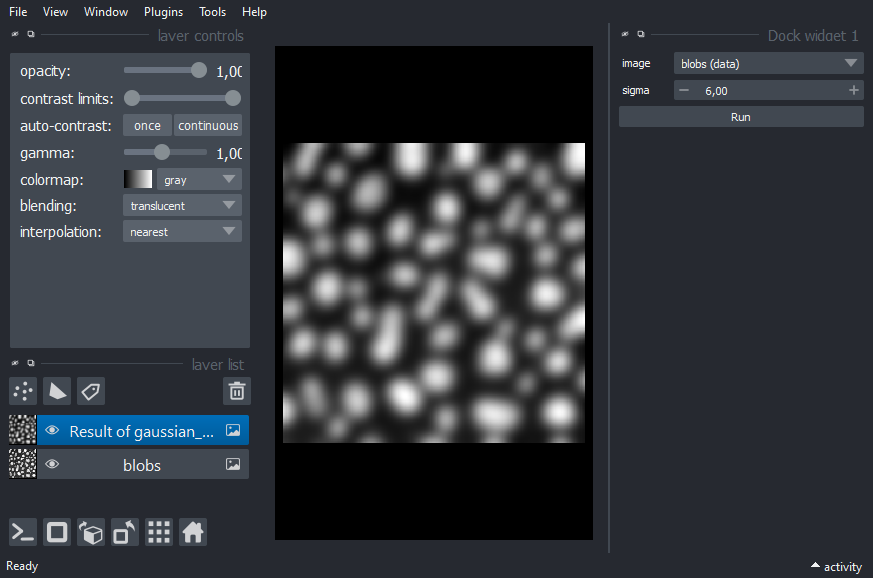

In [8]:
viewer3 = napari.Viewer()
viewer3.add_image(blobs)

layers = viewer3.layers
for i, wf_step_name in enumerate(root_functions):
    func = workflow._tasks[wf_step_name][0]
    args = workflow._tasks[wf_step_name][1:] 
    
    signat = signature_w_kwargs_from_function(func, args)
    func.__signature__ = signat
    widget = make_gui(func, viewer3)
    
    
    viewer3.window.add_dock_widget(widget)
    widget(layers[i].data)

napari.utils.nbscreenshot(viewer3)

In [9]:
def direct_follower_of_node(workflow, workflow_step):
    for step, task in workflow._tasks.items():
            for source in task:
                if isinstance(source, str):
                    if source == workflow_step:
                        return step

print(direct_follower_of_node(workflow,root_functions[0]))                    

Result of Percentile (scipy, nsbatwm)


In [10]:
appendable_roots = root_functions
for root in appendable_roots:
    print('root: ' + str(root))
    followers = [direct_follower_of_node(workflow,root)]
    for follower in followers:
        print(follower)
        # insert check if all the requirements are made
        # if not skip this step and append current node to the node list
        sources = workflow.sources_of(follower)
        if len(sources) == 1: # this means only functions with imge -> image work (for now)
            source = sources[0]
            print('source: ' + str (source))
            
            func = workflow._tasks[follower][0]
            args = workflow._tasks[follower][1:]
            
            signat = signature_w_kwargs_from_function(func, args)
            func.__signature__ = signat
            
            widget = make_gui(func, viewer3)
            viewer3.window.add_dock_widget(widget)
            
            widget(layers[old_to_new_name_mapping[source]].data)
            
            new_direct_follower = direct_follower_of_node(workflow,follower)
            print('new follower: ' + str(new_direct_follower))
            followers.append(new_direct_follower)

root: Result of Gaussian (scikit-image, nsbatwm)
Result of Percentile (scipy, nsbatwm)
source: Result of Gaussian (scikit-image, nsbatwm)
new follower: Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm)
Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm)
source: Result of Percentile (scipy, nsbatwm)
new follower: Result of Seeded watershed using local minima as seeds (nsbatwm)
Result of Seeded watershed using local minima as seeds (nsbatwm)
source: Result of Threshold (Ridler et al 1978, scikit-image, nsbatwm)
new follower: Result of Remove labeled objects at the image border (scikit-image, nsbatwm)
Result of Remove labeled objects at the image border (scikit-image, nsbatwm)
source: Result of Seeded watershed using local minima as seeds (nsbatwm)
new follower: None
None


In [12]:
wf_manager = nw.WorkflowManager.install(viewer3)
manager_wf = wf_manager.workflow
print(manager_wf)

Workflow:
Result of gaussian_blur <- (<function gaussian_blur at 0x000002B6B7468EE0>, 'blobs', 6.0, Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 126.5, 127.5), zoom=1.180078125, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(34.5569353846614, 223.25636755164274), scaled=True, size=10, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 254.0, 1.0), (0.0, 256.0, 1.0)), current_step=(127, 128), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=-1, shape=(-1, -1), enabled=False), layers=[<Image layer 'blobs' at 0x2b6b6f85ba0>, <Image layer 'Result of gaussian_blur' at 0x2b6c6c73460>, <Image layer 'Result of percentile_filter' at 0x2b6c7649930>, <Labels layer 'Result of threshold_mean' at 0x2b6c76d50c0>, <Labels layer 'Result of local_minima_seeded_watershed' at 0x2b6c77980a0>, <Labels layer 'Result of remove_labels_on_edges' 

In [15]:
from napari import Viewer

def clean_workflow(workflow):
    for step, parameters in workflow._tasks.items():
        print_params = tuple([param for param in parameters if not isinstance(param,Viewer)])
        print(new_params)
            
clean_workflow(manager_wf)

(<function gaussian_blur at 0x000002B6B7468EE0>, 'blobs', 6.0)
(<function percentile_filter at 0x000002B6B7469240>, 'Result of gaussian_blur', 6.0, 9.0)
(<function threshold_mean at 0x000002B6B7468AF0>, 'Result of percentile_filter')
(<function local_minima_seeded_watershed at 0x000002B6B746A170>, 'Result of threshold_mean', 5.0, 6.0)
(<function remove_labels_on_edges at 0x000002B6B7469C60>, 'Result of local_minima_seeded_watershed')
